In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
from scipy.interpolate import interpn
from scipy.ndimage import gaussian_filter

In [26]:
# Create a class Image3D
class Image3D:

    # Initialise the class
    def __init__(self, image, voxel_dimension = ()):
        self.image = image
        self.voxel_dimension = voxel_dimension

    # Define a local image coordinate system
        x_coords, y_coords, z_coords = np.mgrid[:self.image.shape[0], :self.image.shape[1], :self.image.shape[2]]
        # Create a 3D array of coordinates
        # The voxel coordinates in this coordinate system correspond to the indices of the voxels in the image data array.
        #self.voxel_coords = np.stack([x_coords, y_coords, z_coords], axis = -1)
        self.voxel_coords=np.vstack((x_coords.flatten(), y_coords.flatten(), z_coords.flatten())).T
        
        ## The voxel_coords variable is a 3D array of shape (self.image.shape[0], self.image.shape[1], self.image.shape[2], 3)
        #  that stores the voxel coordinates in the local image coordinate system.
        # The first three dimensions correspond to the indices of the voxels in the image data array, and the last dimension stores the x, y, and z coordinates of each voxel.
        #self.coords = np.vstack((x_coords.flatten(), y_coords.flatten(), z_coords.flatten())).T

        ## The voxel coordinates are stored as integers,
        # so if you want to convert them to physical coordinates (i.e., coordinates in millimeters or some other unit),
        # you will need to multiply them by the voxel size.
        
        #self.physical_coords = self.voxel_coords * self.voxel_dimension
        self.voxel_coords = self.voxel_coords * self.voxel_dimension


    # Implement volume_resize which resizes the image data array to a new size
    def volume_resize(self, resize_ratio):

        # Compute the new voxel dimensions by multiplying the original voxel dimensions by the ratio
        new_voxel_dimension = tuple(np.array(self.voxel_dimension) / resize_ratio)

        # Compute the new shape of the resized image by multiplying the original shape by the ratio
        #new_shape  = np.round(np.array(self.image.shape) * resize_ratio)
        new_shape  = np.round(np.array(self.image.shape) * resize_ratio).astype(int)

        
        # Create a 3D array of coordinates in the new coordinate system; We multiply the new coordinates by the new voxel dimensions to convert them to physical coordinates (i.e., coordinates in millimeters or some other unit)
        new_coords = np.stack(np.mgrid[:new_shape[0], :new_shape[1], :new_shape[2]], axis = -1) * new_voxel_dimension

        # Divide the new coordinates by the resize ratio to convert them to the original coordinate system
        #new_coords = new_coords / resize_ratio
        
        
        # Interpolate the data array at the new coordinates
        new_data = interpn((np.arange(self.image.shape[0])*self.voxel_dimension[0], np.arange(self.image.shape[1])*self.voxel_dimension[1], np.arange(self.image.shape[2])*self.voxel_dimension[2]),
         self.image, 
         new_coords, 
         method = 'linear', 
         bounds_error = False,
         fill_value = None)

        return Image3D(new_data, new_voxel_dimension)

    # Implement volume_resize_antialias which applies a Gaussian filter to the original image before interpolation
    def volume_resize_antialias(self, resize_ratio, sigma):
        
        # Apply a Gaussian filter to the original image; filtered image is the same size as the original image
        # When finding the sigma value, we divide the voxel dimension by the sigma value as a rule of thumb
        filtered_image = gaussian_filter(self.image, sigma = np.array(self.voxel_dimension)/sigma)
        #filtered_image = gaussian_filter(self.image, sigma = sigma / np.array(self.voxel_dimension))

        # Compute the new voxel dimensions by multiplying the original voxel dimensions by the ratio
        new_voxel_dimension = tuple(np.array(self.voxel_dimension) / resize_ratio)

        # Compute the new shape of the resized image by multiplying the original shape by the ratio
        new_shape  = np.round(np.array(self.image.shape) * resize_ratio).astype(int)

        # Create a 3D array of coordinates in the new coordinate system; We multiply the new coordinates by the new voxel dimensions to convert them to physical coordinates (i.e., coordinates in millimeters or some other unit)
        new_coords = np.stack(np.mgrid[:new_shape[0], :new_shape[1], :new_shape[2]], axis = -1) * new_voxel_dimension

        # Divide the new coordinates by the resize ratio to convert them to the original coordinate system
       # new_coords = new_coords / resize_ratio

        # Interpolate the data array from the filtered image
        new_data = interpn((np.arange(self.image.shape[0])*self.voxel_dimension[0], np.arange(self.image.shape[1])*self.voxel_dimension[1],np.arange(self.image.shape[2])*self.voxel_dimension[2]),
        filtered_image, new_coords,
        method = 'linear',
        bounds_error = False,
        fill_value = None)

        return Image3D(new_data, new_voxel_dimension)







In [2]:
0.5*(32/16)

1.0

## Experiment 1: Up sampling
In this experiment, the image volume is increased


In [13]:
0.5/0.6

0.8333333333333334

Original image shape:  (32, 128, 128) Resized image shape:  (5, 77, 77) Original voxel dimension:  (2, 0.5, 0.5) Resized voxel dimension:  (13.333333333333334, 0.8333333333333334, 0.8333333333333334)


Text(0.5, 1.0, 'Rescaled')

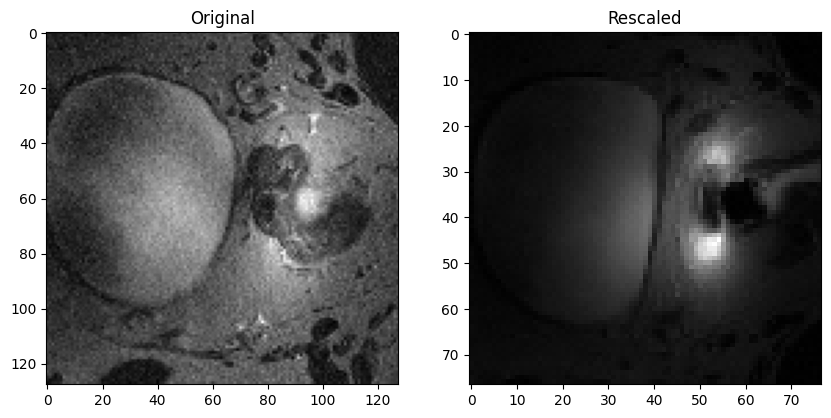

In [27]:
# Load the data into a numpy array
image_train00 = np.load("image_train00.npy")
# Create an Image3D object
# Voxel dimesnions are (z, x, y) = (2, 0.5, 0.5)
image3d = Image3D(image_train00, (2, 0.5, 0.5))

# Desired final isotropic voxel dimension
final_voxel_dimension = (0.3)

# Compute the resize ratio
resize_ratio = final_voxel_dimension / np.array(image3d.voxel_dimension)


# Resize the image
resized_image = image3d.volume_resize(resize_ratio)

# Print the original and resized image shapes
print("Original image shape: ", image3d.image.shape, "Resized image shape: ", resized_image.image.shape, "Original voxel dimension: ", image3d.voxel_dimension, "Resized voxel dimension: ", resized_image.voxel_dimension)

# Visualize example slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image3d.image.T[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(resized_image.image.T[:,:,4], cmap='gray')
ax2.set_title('Rescaled')



In [9]:
resized_image.new_coords

AttributeError: 'Image3D' object has no attribute 'new_coords'

## Downsampling

In [16]:
# Load the data into a numpy array
image_train00 = np.load("image_train00.npy")
# Create an Image3D object
# Voxel dimesnions are (z, x, y) = (2, 0.5, 0.5)
image3d = Image3D(image_train00, (2, 0.5, 0.5))

# Desired final isotropic voxel dimension
final_voxel_dimension = 0.8

# Compute the resize ratio
resize_ratio = final_voxel_dimension / np.array(image3d.voxel_dimension)


# Resize the image
resized_image = image3d.volume_resize(resize_ratio)


Original image shape:  (32, 128, 128) Resized image shape:  (13, 205, 205) Original voxel dimension:  (2, 0.5, 0.5) Resized voxel dimension:  (0.8, 0.8, 0.8)


Text(0.5, 1.0, 'Rescaled')

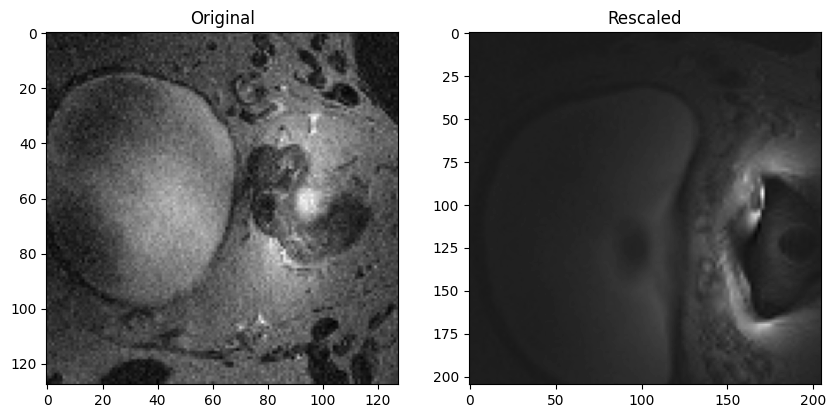

In [18]:

# Print the original and resized image shapes
print("Original image shape: ", image3d.image.shape, "Resized image shape: ", resized_image.image.shape, "Original voxel dimension: ", image3d.voxel_dimension, "Resized voxel dimension: ", resized_image.voxel_dimension)

# Visualize example slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image3d.image.T[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(resized_image.image.T[:,:,12], cmap='gray')
ax2.set_title('Rescaled')


In [7]:
resized_image.voxel_coords

array([[[[  0. ,   0. ,   0. ],
         [  0. ,   0. ,   1.2],
         [  0. ,   0. ,   2.4],
         ...,
         [  0. ,   0. , 364.8],
         [  0. ,   0. , 366. ],
         [  0. ,   0. , 367.2]],

        [[  0. ,   1.2,   0. ],
         [  0. ,   1.2,   1.2],
         [  0. ,   1.2,   2.4],
         ...,
         [  0. ,   1.2, 364.8],
         [  0. ,   1.2, 366. ],
         [  0. ,   1.2, 367.2]],

        [[  0. ,   2.4,   0. ],
         [  0. ,   2.4,   1.2],
         [  0. ,   2.4,   2.4],
         ...,
         [  0. ,   2.4, 364.8],
         [  0. ,   2.4, 366. ],
         [  0. ,   2.4, 367.2]],

        ...,

        [[  0. , 364.8,   0. ],
         [  0. , 364.8,   1.2],
         [  0. , 364.8,   2.4],
         ...,
         [  0. , 364.8, 364.8],
         [  0. , 364.8, 366. ],
         [  0. , 364.8, 367.2]],

        [[  0. , 366. ,   0. ],
         [  0. , 366. ,   1.2],
         [  0. , 366. ,   2.4],
         ...,
         [  0. , 366. , 364.8],
         [  

In [3]:
np.linspace(-9/2, 9/2, 10)

array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

In [37]:
filtered_image = gaussian_filter(image3d.image, sigma = np.array(image3d.voxel_dimension)/5)
filtered_image

array([[[ 54,  53,  96, ...,  83,  54,  55],
        [ 45, 100,  44, ...,  49,  67,  66],
        [ 79,  67,  62, ..., 112, 135,  63],
        ...,
        [ 53,  95, 107, ...,  50,  64,  66],
        [109,  72,  74, ..., 100, 111,  82],
        [ 74, 118, 138, ...,  95,  68,  55]],

       [[ 65,  64,  86, ...,  60,  63,  66],
        [ 64,  68,  86, ...,  64,  70,  66],
        [ 79,  64,  88, ..., 130, 208, 117],
        ...,
        [ 67,  85,  76, ...,  87,  81,  67],
        [ 77,  96,  74, ...,  64,  81,  73],
        [ 73,  77,  82, ...,  60,  92,  84]],

       [[ 90,  33,  83, ...,  59,  82,  58],
        [ 58,  85,  75, ...,  93,  95, 102],
        [ 75,  80,  53, ..., 194, 173, 149],
        ...,
        [ 64,  80,  84, ...,  72,  49,  90],
        [ 66,  88,  68, ...,  80,  94,  84],
        [ 59,  80,  59, ...,  74,  63,  65]],

       ...,

       [[ 58,  88,  98, ..., 154, 108,  82],
        [ 68,  79, 101, ..., 148,  90,  94],
        [ 84,  77,  60, ..., 143, 164, 104

In [38]:
image3d.image

array([[[ 54,  53,  97, ...,  85,  54,  55],
        [ 45, 102,  43, ...,  49,  67,  67],
        [ 79,  68,  61, ..., 112, 132,  61],
        ...,
        [ 53,  96, 109, ...,  49,  64,  66],
        [111,  71,  74, ..., 102, 113,  83],
        [ 75, 120, 141, ...,  97,  67,  54]],

       [[ 65,  66,  86, ...,  60,  63,  67],
        [ 66,  66,  89, ...,  64,  69,  65],
        [ 80,  64,  91, ..., 129, 214, 118],
        ...,
        [ 68,  85,  75, ...,  90,  84,  66],
        [ 76,  98,  75, ...,  62,  79,  73],
        [ 74,  75,  81, ...,  58,  95,  87]],

       [[ 92,  31,  83, ...,  59,  84,  57],
        [ 57,  87,  75, ...,  95,  98, 103],
        [ 74,  81,  51, ..., 195, 171, 152],
        ...,
        [ 65,  81,  86, ...,  71,  46,  93],
        [ 66,  89,  67, ...,  81,  95,  85],
        [ 58,  81,  57, ...,  75,  61,  63]],

       ...,

       [[ 55,  88,  99, ..., 153, 108,  82],
        [ 68,  80, 102, ..., 147,  88,  94],
        [ 85,  77,  58, ..., 143, 168, 102

In [28]:
5/np.array(image3d.voxel_dimension)

array([ 2.5, 10. , 10. ])

In [29]:
np.array(image3d.voxel_dimension)/5

array([0.4, 0.1, 0.1])

In [30]:
np.array(image3d.voxel_dimension)*5

array([10. ,  2.5,  2.5])

In [3]:
# Download the image data
link = "https://weisslab.cs.ucl.ac.uk/WEISSTeaching/datasets/-/raw/promise12/image_train00.npy"

!wget -q -O image_train00.npy $link


In [ ]:
# # Load the data into a numpy array
# image_train00 = np.load("image_train00.npy").T

# # Visualize 5 random slices in the image data
# fig, ax = plt.subplots(5, 1, figsize = (15, 15))
# for i in range(5):
#     ax[i].imshow(image_train00[:, :, np.random.randint(image_train00.shape[2])], cmap = "gray")
#     ax[i].axis("off")
    

In [3]:
# Load the data into a numpy array
image_train00 = np.load("image_train00.npy")
image_train00.shape

(32, 128, 128)

In [ ]:

# Set the number of rows and columns in the plot grid
n_rows = 6
n_cols = 6

# Create a figure with a subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Iterate over the slices of the image
for row in range(n_rows):
    for col in range(n_cols):
        slice_idx = row * n_cols + col
        if slice_idx >= image_train00.T.shape[2]:
            break
        slice_data = image_train00.T[:, :, slice_idx]
        axs[row, col].imshow(slice_data, cmap='gray')
        # Add title to each subplot
        axs[row, col].set_title(f'Slice {slice_idx}')

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

### Volume resizing

Implement three scenarios:

- `Upsampling`
- `Downsampling`
- `Resampling`

such that the resized volume has an isotropic voxel dimension.

`Isotropic volume means that the volume is same in all directions.`

The image has the following voxel dimensions: contains a volumetric image with an axial in-plane pixel
spacing of 0.5 mm/voxel and a slice distance of 2 mm/voxel.


Implement a class member function volume_resize, which takes an input of three-item tuple,
which specifies the resize ratio, i.e. the resized image size should be the original image size
multiple by this ratio

In [ ]:
xyz=np.vstack((x_coords.flatten(), y_coords.flatten(), z_coords.flatten())).T
new_coords = (np.stack(np.mgrid[:new_shape[0].flatten(), :new_shape[1].flatten(), :new_shape[2]], axis = -1) * new_voxel_dimension) / resize_ratio

In [10]:
# Load the data into a numpy array
image_train00 = np.load("image_train00.npy")
# Create an Image3D object
# Voxel dimesnions are (z, x, y) = (2, 0.5, 0.5)
image3d = Image3D(image_train00, (2, 0.5, 0.5))


In [11]:

# Desired final isotropic voxel dimension
final_voxel_dimension = (1)

# Compute the resize ratio
resize_ratio = final_voxel_dimension / np.array(image3d.voxel_dimension)

# Compute the new voxel dimensions by multiplying the original dimensions by the ratio
new_voxel_dimension = tuple(np.array(image3d.voxel_dimension) / resize_ratio)


## the resized image size should be the original image size multipled by this ratio

# Compute the new shape of the resized image by multiplying the original shape by the ratio
new_shape  = np.round(np.array(image3d.image.shape) * resize_ratio).astype(int)


# New coordinates for the resized image
new_coords = (np.stack(np.mgrid[:new_shape[0], :new_shape[1], :new_shape[2]], axis = -1) * new_voxel_dimension)
#new_coords = (np.stack(np.mgrid[:new_shape[0], :new_shape[1], :new_shape[2]], axis = -1) * new_voxel_dimension)


In [16]:
new_shape

array([ 16, 256, 256])

In [14]:
new_coords.reshape(3, -1)[0]

array([[ 0.  ,  0.  ,  0.  , ..., 21.25, 21.  , 20.  ],
       [21.25, 21.25, 20.  , ..., 42.25, 40.  , 42.5 ],
       [42.5 , 40.  , 42.5 , ..., 60.  , 63.75, 63.75]])

In [ ]:


# Interpolate the filtered data array at the new coordinates
# Cubic interpolation not supported in scipy 1.9.0
new_data = interpn(np.array((np.arange(image3d.image.shape[0]), np.arange(image3d.image.shape[1]), np.arange(image3d.image.shape[2])) * (2, 0.5, 0.5)), image3d.image, new_coords, method = 'linear', bounds_error = False, fill_value = None)
#new_data = interpn((image3d.voxel_coords[:,0], image3d.voxel_coords[:,1], image3d.voxel_coords[:,1]), image3d.image, new_coords, method = 'linear', bounds_error = False, fill_value = None)
#new_data = new_data.astype(np.int16)

print(image3d.image.shape, resize_ratio, new_shape, new_voxel_dimension, new_data.shape)


In [26]:
image3d.voxel_coords[:,0]


array([ 0.,  0.,  0., ..., 62., 62., 62.])

In [28]:
image3d.voxel_coords[:,1]

array([ 0. ,  0. ,  0. , ..., 63.5, 63.5, 63.5])

In [16]:
image3d.image.shape

(32, 128, 128)

In [9]:
image3d.voxel_coords.shape


(32, 128, 128, 3)

In [12]:
new_coords.shape

(8, 128, 128, 3)

In [17]:
new_data

array([[[    54,     57,     94, ...,    234,    236,    237],
        [    48,     93,     50, ...,  -1210,  -1218,  -1226],
        [    78,     73,     62, ...,  -8445,  -8497,  -8550],
        ...,
        [ -6401,   9261,   6063, ...,  18398,  21748,  25098],
        [ -6441,   9316,   6099, ...,  21730,  25101,  28471],
        [ -6480,   9372,   6136, ...,  25062,  28453,  31844]],

       [[    67,     64,     79, ...,    227,    228,    229],
        [    66,     69,     84, ...,  -2016,  -2029,  -2041],
        [    80,     77,     85, ..., -10236, -10299, -10363],
        ...,
        [  -395,  -3326,   1833, ..., -18722, -18848, -18975],
        [  -398,  -3346,   1844, ..., -18829, -18956, -19083],
        [  -401,  -3367,   1855, ..., -18936, -19064, -19192]],

       [[    88,     42,     82, ...,  -3321,  -3342,  -3362],
        [    63,     83,     73, ...,   1732,   1742,   1752],
        [    78,     86,     68, ...,  -2204,  -2219,  -2233],
        ...,
        [ -1

In [35]:
image3d.image

array([[[ 54,  53,  97, ...,  85,  54,  55],
        [ 45, 102,  43, ...,  49,  67,  67],
        [ 79,  68,  61, ..., 112, 132,  61],
        ...,
        [ 53,  96, 109, ...,  49,  64,  66],
        [111,  71,  74, ..., 102, 113,  83],
        [ 75, 120, 141, ...,  97,  67,  54]],

       [[ 65,  66,  86, ...,  60,  63,  67],
        [ 66,  66,  89, ...,  64,  69,  65],
        [ 80,  64,  91, ..., 129, 214, 118],
        ...,
        [ 68,  85,  75, ...,  90,  84,  66],
        [ 76,  98,  75, ...,  62,  79,  73],
        [ 74,  75,  81, ...,  58,  95,  87]],

       [[ 92,  31,  83, ...,  59,  84,  57],
        [ 57,  87,  75, ...,  95,  98, 103],
        [ 74,  81,  51, ..., 195, 171, 152],
        ...,
        [ 65,  81,  86, ...,  71,  46,  93],
        [ 66,  89,  67, ...,  81,  95,  85],
        [ 58,  81,  57, ...,  75,  61,  63]],

       ...,

       [[ 55,  88,  99, ..., 153, 108,  82],
        [ 68,  80, 102, ..., 147,  88,  94],
        [ 85,  77,  58, ..., 143, 168, 102

In [25]:
rescaled_volume.T

array([[[ 61.27538109,  61.27538109,  63.45341794, ...,  62.5732244 ,
          62.73383737,  62.73383737],
        [ 61.27538109,  61.27538109,  63.45341794, ...,  62.5732244 ,
          62.73383737,  62.73383737],
        [ 62.3635268 ,  62.3635268 ,  72.10804787, ...,  67.00903571,
          66.48725433,  66.48725433],
        ...,
        [ 87.02463881,  87.02463881,  87.64041884, ...,  87.66879126,
          80.10768702,  80.10768702],
        [ 81.70561031,  81.70561031,  89.18510656, ...,  81.39307035,
          75.64036841,  75.64036841],
        [ 81.70561031,  81.70561031,  89.18510656, ...,  81.39307035,
          75.64036841,  75.64036841]],

       [[ 73.89027042,  73.89027042,  63.9671209 , ...,  75.31508977,
          76.33790285,  76.33790285],
        [ 73.89027042,  73.89027042,  63.9671209 , ...,  75.31508977,
          76.33790285,  76.33790285],
        [ 72.55622044,  72.55622044,  73.20444333, ...,  83.66697342,
          92.16721085,  92.16721085],
        ...,


In [19]:
new_data

array([[[ 54.  ,  53.5 ,  53.  , ...,  54.5 ,  55.  ,  55.5 ],
        [ 49.5 ,  63.5 ,  77.5 , ...,  60.75,  61.  ,  61.25],
        [ 45.  ,  73.5 , 102.  , ...,  67.  ,  67.  ,  67.  ],
        ...,
        [ 93.  ,  94.25,  95.5 , ...,  79.25,  68.5 ,  57.75],
        [ 75.  ,  97.5 , 120.  , ...,  60.5 ,  54.  ,  47.5 ],
        [ 57.  , 100.75, 144.5 , ...,  41.75,  39.5 ,  37.25]],

       [[ 92.  ,  61.5 ,  31.  , ...,  70.5 ,  57.  ,  43.5 ],
        [ 74.5 ,  66.75,  59.  , ...,  85.5 ,  80.  ,  74.5 ],
        [ 57.  ,  72.  ,  87.  , ..., 100.5 , 103.  , 105.5 ],
        ...,
        [ 62.  ,  73.5 ,  85.  , ...,  76.  ,  74.  ,  72.  ],
        [ 58.  ,  69.5 ,  81.  , ...,  62.  ,  63.  ,  64.  ],
        [ 54.  ,  65.5 ,  77.  , ...,  48.  ,  52.  ,  56.  ]],

       [[ 77.  ,  76.  ,  75.  , ...,  83.5 ,  85.  ,  86.5 ],
        [ 78.  ,  74.5 ,  71.  , ...,  74.75,  84.5 ,  94.25],
        [ 79.  ,  73.  ,  67.  , ...,  66.  ,  84.  , 102.  ],
        ...,
        [ 78

Text(0.5, 1.0, 'Rescaled')

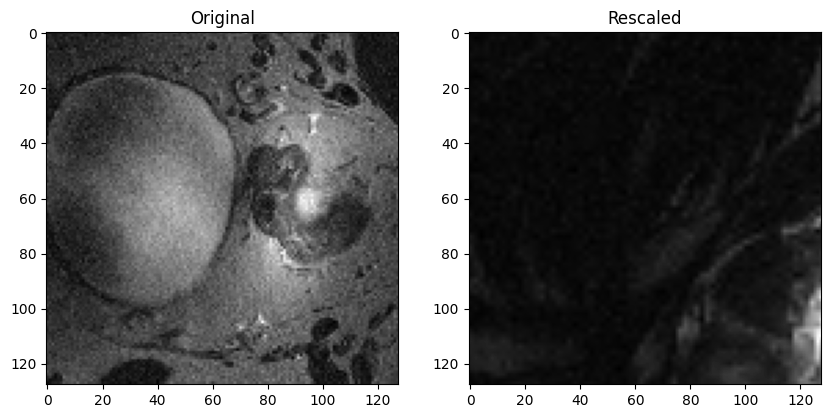

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image3d.image.T[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(new_data.T[:,:,1], cmap='gray')
ax2.set_title('Rescaled')

Text(0.5, 1.0, 'Rescaled')

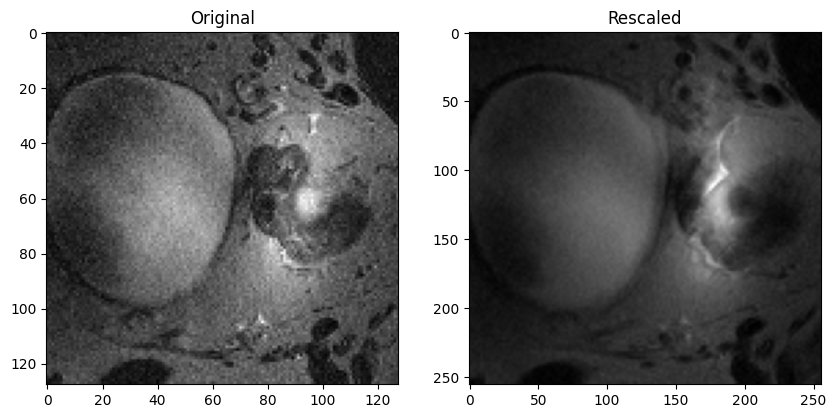

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(volume[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(rescaled_volume[:,:,15], cmap='gray')
ax2.set_title('Rescaled')

In [28]:
np.array(image3d.voxel_dimension)/2

array([1.  , 0.25, 0.25])

Text(0.5, 1.0, 'Filtered')

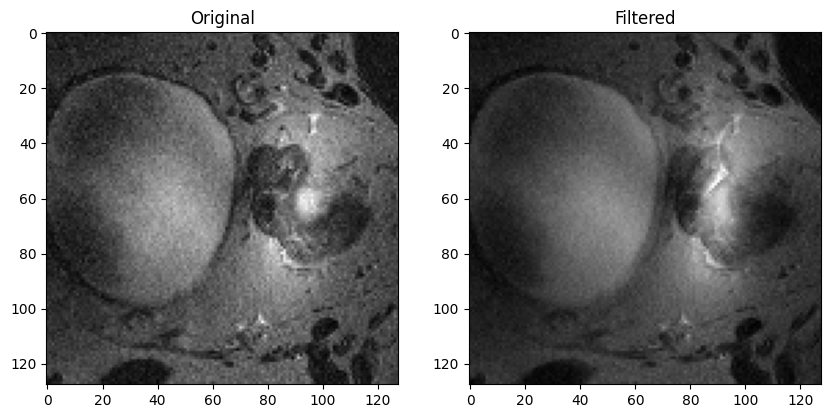

In [29]:
filtered_image = gaussian_filter(np.load('image_train00.npy'), sigma = np.array(image3d.voxel_dimension)/2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image3d.image.T[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(filtered_image.T[:,:,31], cmap='gray')
ax2.set_title('Filtered')

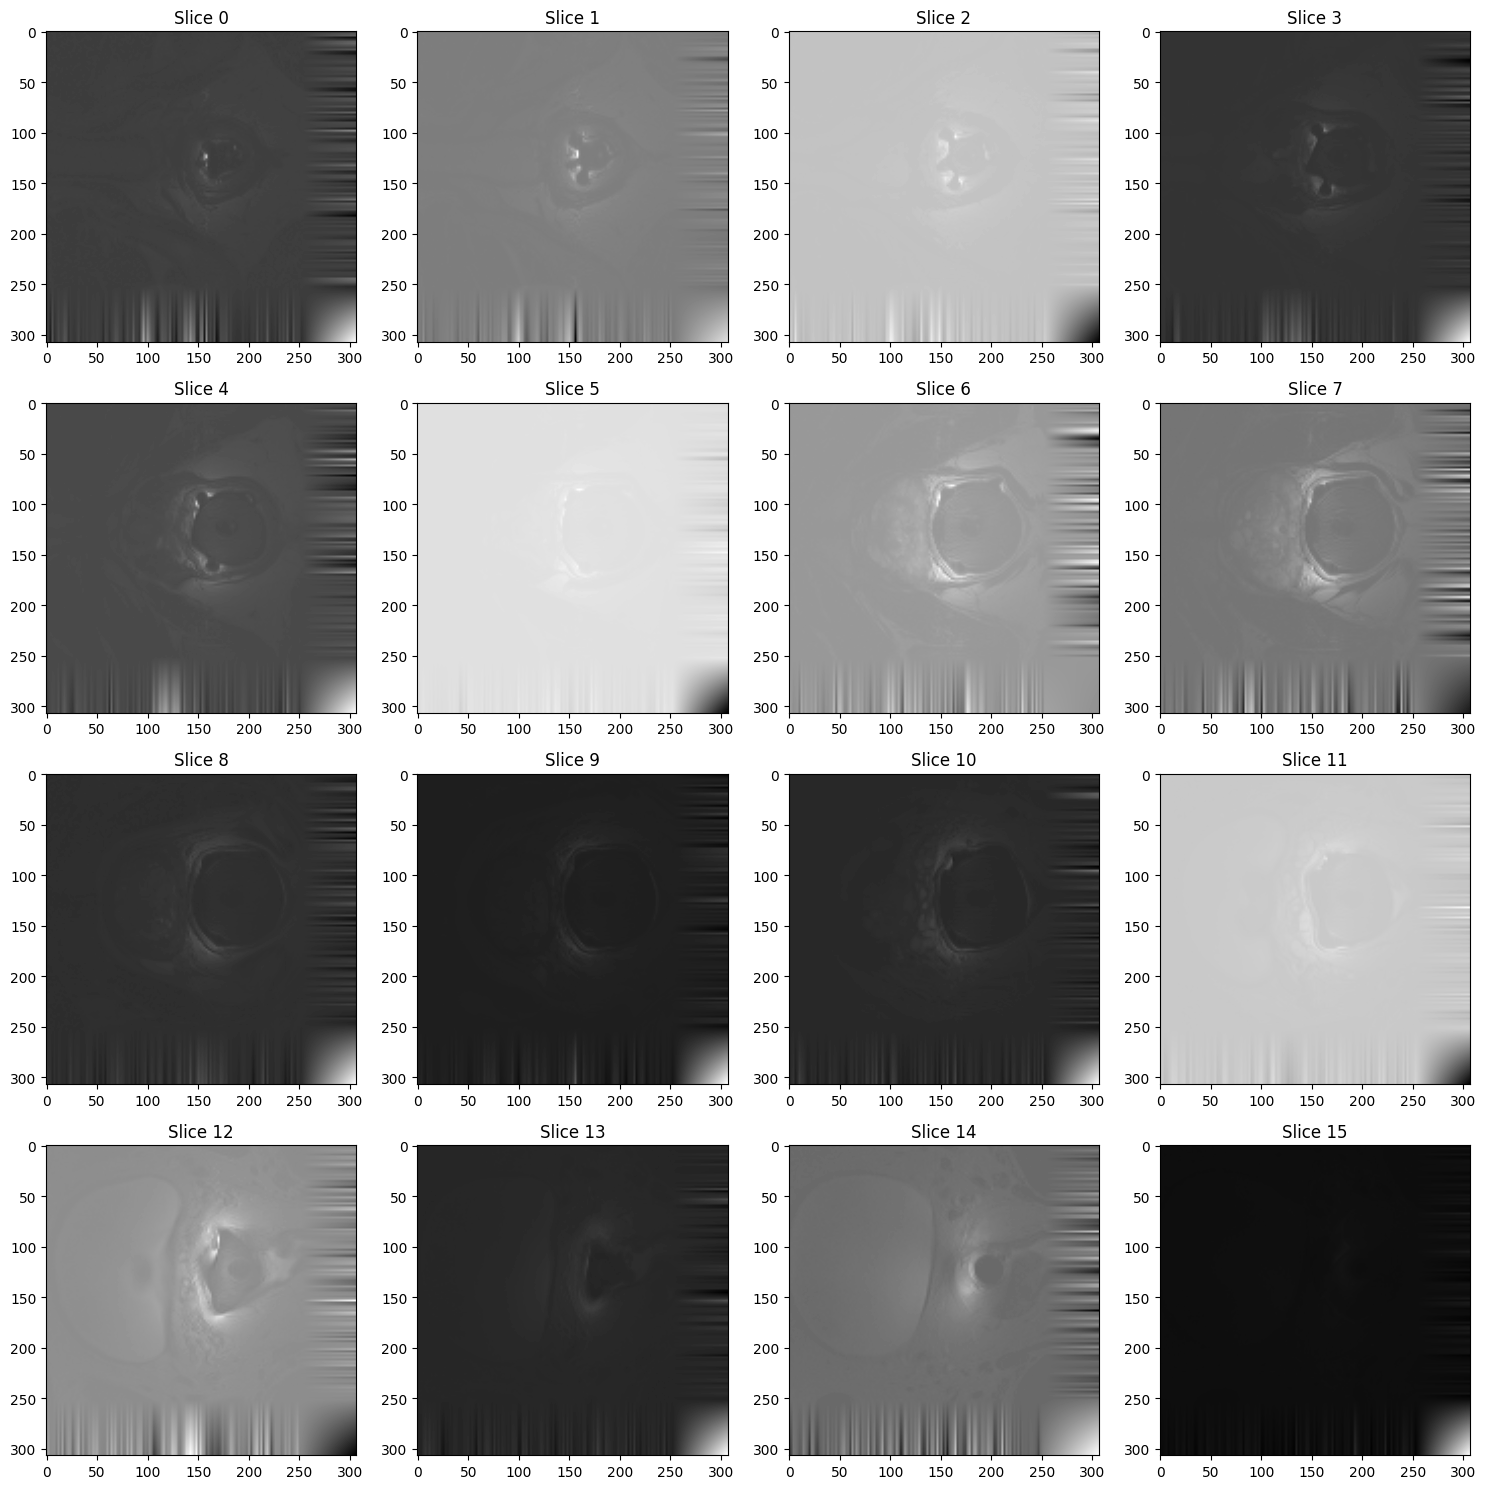

In [21]:
new_datap = new_data.T
#new_datap = filtered_image.T
#new_datap = image3d.image.T
# Set the number of rows and columns in the plot grid
n_rows = 4
n_cols = 4

# Create a figure with a subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Iterate over the slices of the image
for row in range(n_rows):
    for col in range(n_cols):
        slice_idx = row * n_cols + col
        if slice_idx >= new_datap.shape[2]:
            break
        slice_data = new_datap[:, :, slice_idx]
        axs[row, col].imshow(slice_data, cmap='gray')
        # Add title to each subplot
        axs[row, col].set_title(f'Slice {slice_idx}')

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

In [48]:
image_train00.shape

(32, 128, 128)

In [41]:
image3d.voxel_dimension

(0.5, 0.5, 2)

In [45]:
new_coords = np.stack(np.mgrid[:new_shape[0], :new_shape[1], :new_shape[2]], axis = -1)
new_coords.shape

(64, 256, 64, 3)

In [34]:
image3d.voxel_dimension

(0.5, 0.5, 2)

In [18]:
# Upsample an image using class Image3D
upsampled_image3d = image3d.volume_resize()

(0.5, 0.5, 2)

In [20]:
image3d.image[1].shape

(128, 128)

In [ ]:
def volume_resize(self, resize_ratio):

        # Compute the new shape of the resized image by multiplying the original shape by the ratio
        new_shape  = np.round(np.array(self.image.shape) * resize_ratio).astype(int)
        new_coords = np.stack(np.mgrid[:new_shape[0], :new_shape[1], :new_shape[2]], axis = -1)
        #new_coords = new_coords / resize_ratio
        
        # Compute the new voxel dimensions by multiplying the original dimensions by the ratio
        new_voxel_dimension = tuple(np.array(self.voxel_dimesnion) * resize_ratio)

        # Interpolate the filtered data array at the new coordinates
        new_data = interpn((np.arange(self.image.shape[0]), np.arange(self.image.shape[1]), np.arange(self.image.shape[2])), self.image, new_coords, method = 'linear', bounds_error = False, fill_value = 0)
        #new_data = interpn((np.arange(s) for s in self.image.shape), self.image, new_shape, method = 'linear', bounds_error = False, fill_values = 0)

        return Image3D(new_data, new_voxel_dimension)

In [30]:
np.array(image3d.voxel_dimension)

array([0.5, 0.5, 2. ])

In [31]:
vd = np.array(image3d.voxel_dimension);vd

array([0.5, 0.5, 2. ])

In [32]:
0.5/vd

array([1.  , 1.  , 0.25])

## Experiment with skimage

In [23]:
import numpy as np
from skimage.transform import rescale

# Load the data into a numpy array
volume = np.load("image_train00.npy").T

# Voxel dimensions
voxel_dimensions = np.array([0.5, 0.5, 2])

# Desired final isotropic voxel dimension
final_voxel_dimension = (0.3)

# Compute the resize ratio required to upsample the volume to the desired final voxel dimension
resize_ratio = final_voxel_dimension / voxel_dimensions

# Resize the volume using the resize ratio
rescaled_volume = rescale(volume, resize_ratio, order = 1, preserve_range = True, multichannel = False)

print(volume.shape, rescaled_volume.shape)


(128, 128, 32) (77, 77, 5)


/tmp/ipykernel_1902/3089989613.py:17: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  rescaled_volume = rescale(volume, resize_ratio, order = 1, preserve_range = True, multichannel = False)


Text(0.5, 1.0, 'Rescaled')

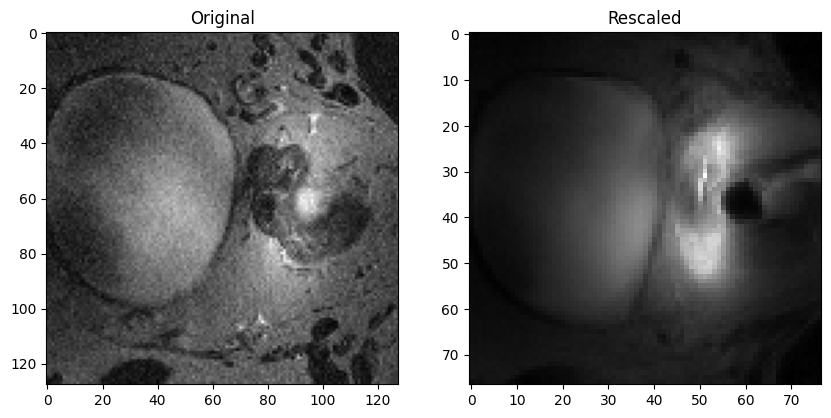

In [25]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(volume[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(rescaled_volume[:,:,4], cmap='gray')
ax2.set_title('Rescaled')

When resizing a volume, it depends on the desired outcome. If the goal is to change the size of the volume while keeping the same amount of information, then the number of slices should be changed. This can be done by resampling the volume, which involves both interpolation and decimation. The resampling process can be done to increase or decrease the number of slices.

However, if the goal is to change the resolution of the volume and maintain the same amount of information, then the number of slices should not be changed. In this case, the resizing process involves interpolation, which increases the resolution of the volume by adding new voxels between existing ones.

It's important to note that when the number of slices is changed, the information present on the volume is also changed, this may lead to loss of information or adding noise to the volume.

In summary, if the goal is to change the size of the volume, the number of slices should be changed, otherwise, it should not be.





In [ ]:
import numpy as np
from scipy.interpolate import interpn

class Image3D:
    def __init__(self, data: np.ndarray, voxel_dimension: tuple):
        self.data = data
        self.voxel_dimension = voxel_dimension
        self.voxel_coordinates = np.array(np.meshgrid(range(data.shape[0]), range(data.shape[1]), range(data.shape[2]), indexing='ij')).T.reshape(-1,3)
        self.voxel_coordinates = self.voxel_coordinates * np.array(voxel_dimension)
    
    def volume_resize(self, ratio: tuple):
        x, y, z = self.voxel_coordinates.T
        new_data = interpn((x, y, z), self.data, (x * ratio[0], y * ratio[1], z * ratio[2]), method='linear', bounds_error=False)
        new_voxel_coordinates = self.voxel_coordinates * np.array(ratio)
        return Image3D(new_data, new_voxel_coordinates)


In [1]:
import numpy as np
from scipy.interpolate import interpn

# Load data
data = np.load("image_train00.npy")

voxel_dimension = np.array((2, 0.5, 0.5))

# Final voxel dimension
final_voxel_dimension = np.array(1)

# Ratio
ratio = final_voxel_dimension / voxel_dimension


#
voxel_coordinates = np.array(np.meshgrid(range(data.shape[0]), range(data.shape[1]), range(data.shape[2]), indexing='ij')).T.reshape(-1,3)

voxel_coordinates = voxel_coordinates * np.array(voxel_dimension)

voxel_coordinates



array([[ 0. ,  0. ,  0. ],
       [ 2. ,  0. ,  0. ],
       [ 4. ,  0. ,  0. ],
       ...,
       [58. , 63.5, 63.5],
       [60. , 63.5, 63.5],
       [62. , 63.5, 63.5]])

In [2]:
x, y, z = voxel_coordinates.T
new_data = interpn((x, y, z), data, (x * ratio[0], y * ratio[1], z * ratio[2]), method='linear', bounds_error=False)
new_voxel_coordinates = voxel_coordinates * np.array(ratio)

ValueError: The points in dimension 0 must be strictly ascending or descending